__This is an illustrative and step-by-step walkthrough of how to build a CNN for image recogntion for Cifar 10 dataset__

__The order of steps is as follows:__

1. Load, epxlore and standardize the data
2. Build the model
3. Train the model on the training dataset
4. Evaluate the model on the test data

* Use data augmentation to improve the final accuracy of the model

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
print(tf.__version__)

import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2.18.0


##### Load and scale the dataset

In [2]:
cifar10 = tf.keras.datasets.cifar10

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Scale the input images to expedite the network training
train_images = train_images / 255.0
test_images = test_images / 255.0

# train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# BATHCH_SIZE = 32

# # Use random shuffle and batching
# train_data, test_data = train_data.shuffle(buffer_size=10000), test_data.shuffle(buffer_size=10000)

# train_data = train_data.batch(BATHCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_data = test_data.batch(BATHCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Attempt 1: The model architecture
The model architecture that we will use as follows:

1. An input layer,
2. Three convolutional layers, a max pooling layer,
3. Another convolution layer, followed by a maxpooling layer,.
4. A flatten layer, and
5. Two dense layers.
6. The last layer is the output layer with 10 neurons, one for each class.
7. Actiation functions in all layers are Relu, except in the last layer, the activation is softmax for multicalss classification.
8. Loss will be sparse categorical cross entropy, and recorded metric will be accuracy

In [13]:
# Model building

# Input layer
model_input = Input(shape=(train_images[0].shape))

# Convolution block 1
interm_out = Conv2D(32, (3, 3), activation='relu')(model_input)
# interim_out = BatchNormalization()(interim_out)

interm_out = Conv2D(64, (3, 3), activation='relu')(interm_out)
# interim_out = BatchNormalization()(interim_out)

# interm_out = Conv2D(128, (3, 3), activation='relu')(interm_out)
interm_out = MaxPooling2D((2, 2))(interm_out)

interm_out = Conv2D(64, (3, 3), activation='relu')(interm_out)
# interim_out = BatchNormalization()(interim_out)

interm_out = MaxPooling2D((2, 2))(interm_out)
interim_out = Flatten()(interm_out)

# Clasification block
interim_out = Dense(512, activation='relu')(interim_out)
final_out = Dense(10, activation='softmax')(interim_out)

# Linking up the model input and output in the model object
model = Model(model_input, final_out)

In [14]:
# Setting up the model training parameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
fit_stats = model.fit(train_images, train_labels, epochs=15, validation_data=(test_images, test_labels))

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4267 - loss: 1.5643 - val_accuracy: 0.6404 - val_loss: 1.0230
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6919 - loss: 0.8798 - val_accuracy: 0.7238 - val_loss: 0.7941
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7673 - loss: 0.6708 - val_accuracy: 0.7290 - val_loss: 0.7960
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8148 - loss: 0.5309 - val_accuracy: 0.7413 - val_loss: 0.7873
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8615 - loss: 0.4007 - val_accuracy: 0.7343 - val_loss: 0.8564
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9030 - loss: 0.2772 - val_accuracy: 0.7302 - val_loss: 0.9829
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9361 - loss: 0.1846 - val_accuracy: 0.7391 - val_loss: 1.0629
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9542 - loss: 0.13

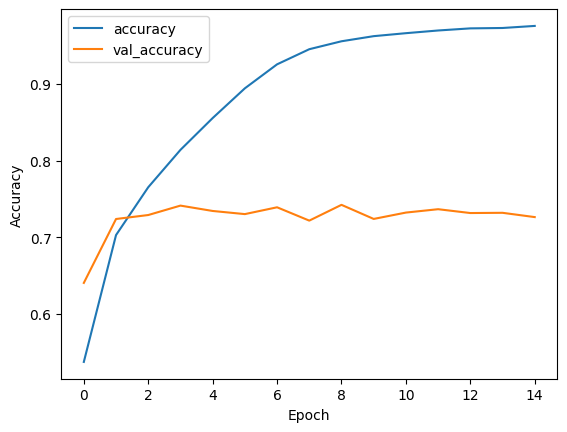

In [15]:
# Plotting the model performance
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

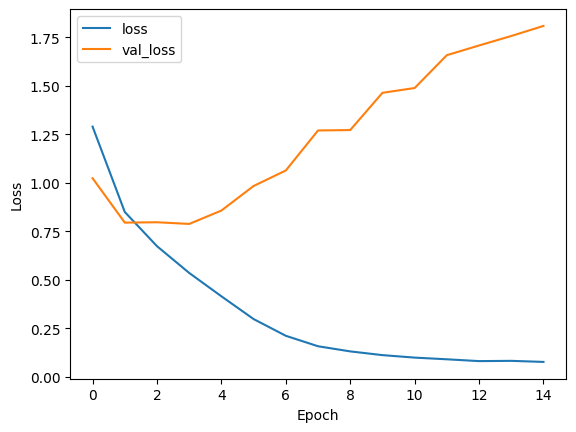

In [16]:
# Plotting the model performance
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

__Results of experiment 1 & Improvements__

10 epochs - The train accuray increases with epochs while validation accuracy decrease after 4 epochs. The train set accuracy reach upto 90%, but the validation set accuracy is only 70%. This indicates that out
network is possibly overfiting the train set. It is better to use lower number of epochs or make the network simpler.

Now, let's try to see if the accuracy can be improved by

1. Using a simpler model: no improvements were seen on a simpler model, except the validatio set set accuracy decreased a bit.

2. __What improved the accuracy is using data augmentation, along with more convolution blocks where successive blocks have more feature maps, also number of epochs must be atleast 20 to see the accuracy beyond 75%, and it appears that the dropout rate should be 0.2 to see early improvements in the accuracy. Changing these parameter values affect the accuracy significanlty__

#### Trying the model training with data augmentation.

In [3]:
# Create data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),  # Rotate by up to 10% (0.2 * 2π radians)
    tf.keras.layers.RandomZoom(0.1)
])

In [4]:
# Model building

# Input layer
model_input = Input(shape=(train_images[0].shape))

# Apply data augmentation
interim_out = data_augmentation(model_input)

# Convolution block 1
interm_out = Conv2D(32, (3, 3), activation='relu', padding='same')(interim_out)
interim_out = BatchNormalization()(interim_out)

interm_out = Conv2D(32, (3, 3), activation='relu', padding='same')(interm_out)
interim_out = BatchNormalization()(interim_out)
interm_out = MaxPooling2D((2, 2))(interm_out)


interm_out = Conv2D(64, (3, 3), activation='relu', padding='same')(interm_out)
interim_out = BatchNormalization()(interim_out)

interm_out = Conv2D(64, (3, 3), activation='relu', padding='same')(interm_out)
interim_out = BatchNormalization()(interim_out)
interm_out = MaxPooling2D((2, 2))(interm_out)

interm_out = Conv2D(128, (3, 3), activation='relu', padding='same')(interm_out)
interim_out = BatchNormalization()(interim_out)

interm_out = Conv2D(128, (3, 3), activation='relu', padding='same')(interm_out)
interim_out = BatchNormalization()(interim_out)
interm_out = MaxPooling2D((2, 2))(interm_out)

interim_out = Flatten()(interm_out)
interm_out = Dropout(0.2)(interim_out)

# Clasification block
interim_out = Dense(1024, activation='relu')(interim_out)
interm_out = Dropout(0.2)(interim_out)

# The number of hidden units in the output layer is 10 because there are 10 classes in the dataset.
final_out = Dense(10, activation='softmax')(interim_out)

# Linking up the model input and output in the model object
model = Model(model_input, final_out)

# Setting up the model training parameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
fit_stats = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels))

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.3150 - loss: 1.8459 - val_accuracy: 0.5328 - val_loss: 1.2787
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.5313 - loss: 1.2954 - val_accuracy: 0.5606 - val_loss: 1.3176
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6010 - loss: 1.1187 - val_accuracy: 0.6576 - val_loss: 0.9792
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6413 - loss: 1.0200 - val_accuracy: 0.6796 - val_loss: 0.9312
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.6655 - loss: 0.9473 - val_accuracy: 0.7071 - val_loss: 0.8497
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.6883 - loss: 0.8850 - val_accuracy: 0.7098 - val_loss: 0.8642
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7054 - loss: 0.8375 - val_accuracy: 0.7077 - val_loss: 0.8743
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7153 -

__Observation:__ We note that, by using a combination of data augmentation, more convolution layers, and increasing the dropout rate actually made the difference. The accuracy is increased to 77% from earlier 73%.

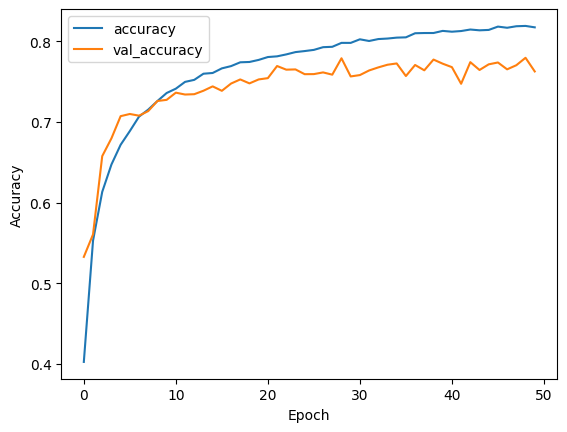

In [5]:
# Plotting the model performance
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

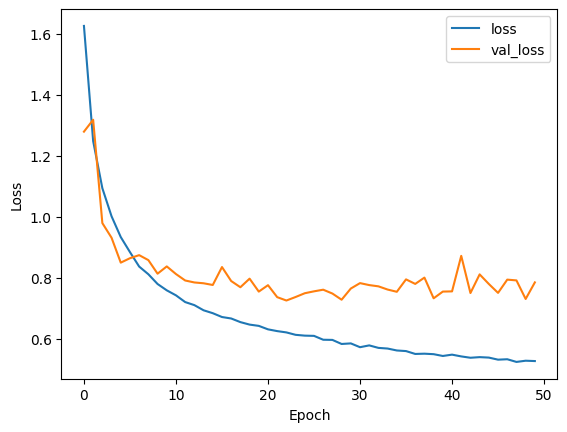

In [6]:
# Plotting the model performance
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()